# Generative Modeling on MNIST with Monotone Gradient Networks

This notebook demonstrates how to use Monotone Gradient Networks (specifically M_MGN) for generative modeling on the MNIST dataset.

We use the framework to learn a map from the data distribution (MNIST) to a Gaussian distribution. Since the learned map is the gradient of a convex function, it is monotone and invertible. We can then generate new images by sampling from the Gaussian and inverting the map.

In [1]:
import sys
import os
from pathlib import Path 

# Add project root to path to allow importing src
current_dir = Path.cwd()
if current_dir.name == "notebooks":
    sys.path.append(str(current_dir.parent))
else:
    sys.path.append(str(current_dir))
    
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from src.monotone_grad_nets.models.cmgn import C_MGN
from src.monotone_grad_nets.trainers.trainer import Trainer
from src.monotone_grad_nets.utils.inversion import invert_gradient_map

# Configuration
BATCH_SIZE = 64
LR = 1e-3
N_EPOCHS = 100 # Increase for better results
HIDDEN_DIM = 128 * 4
NUM_LAYERS = 16 * 2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {DEVICE}")

Using device: cuda


## Data Loading

We load the MNIST dataset and flatten the images to vectors of size 784 (28x28).

In [2]:
# 1. Create a "Noise Loader"
class NoiseDataset(torch.utils.data.Dataset):
    def __init__(self, size, dim):
        self.size = size
        self.dim = dim
    def __len__(self): return self.size
    def __getitem__(self, idx): 
        return torch.randn(self.dim) # Sample Gaussian noise on the fly

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)), # Normalize to [-1, 1]
    transforms.Lambda(lambda x: x.view(-1)) # Flatten
])

train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

input_dim = 28 * 28

noise_loader = DataLoader(NoiseDataset(6000*2, input_dim), batch_size=BATCH_SIZE)

# 2. Prepare Target (Real MNIST images)
# Flatten MNIST to (60000, 784)
mnist_samples = next(iter(DataLoader(train_dataset, batch_size=6000 *2)))[0].view(-1, input_dim)

## Model Initialization

We use an Modular Monotone Gradient Network (M_MGN). The network will learn a convex potential $\psi(x)$, and its gradient $\nabla \psi(x)$ will map MNIST images to Gaussian noise.

In [3]:
model = C_MGN(input_dim=input_dim, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, output_dim=input_dim).to(DEVICE)

print("Number of Trainable Parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of Trainable Parameters:  1033232


## Training



We train the model using the `Trainer` class. We specify `task='optimal_transport'` and we input our MNIST data as target data. We use Sinkhorn Divergence as our loss function to map the mass of $\mathcal N(0, I)$ to the distribution of MNIST.

In [13]:
trainer = Trainer(
    model=trainer.model,
    model_name='cmgn',
    task='optimal_transport',
    n_epochs=200,
    lr=0.01,
    device=DEVICE, 
    use_amp=False, #True if DEVICE == 'cuda' else False,
    accumulation_steps=4,
    criterion="sinkhorn",
    transport_cost_weight=0.2,
    target_data=mnist_samples,
    scheduler="plateau", 
)

# Train using the Trainer class
trainer.train(noise_loader)

Epoch 200 | Train Loss: 100.3250 | Train Cost: 1243.4553 | : 100%|██████████| 200/200 [39:41<00:00, 11.91s/it]


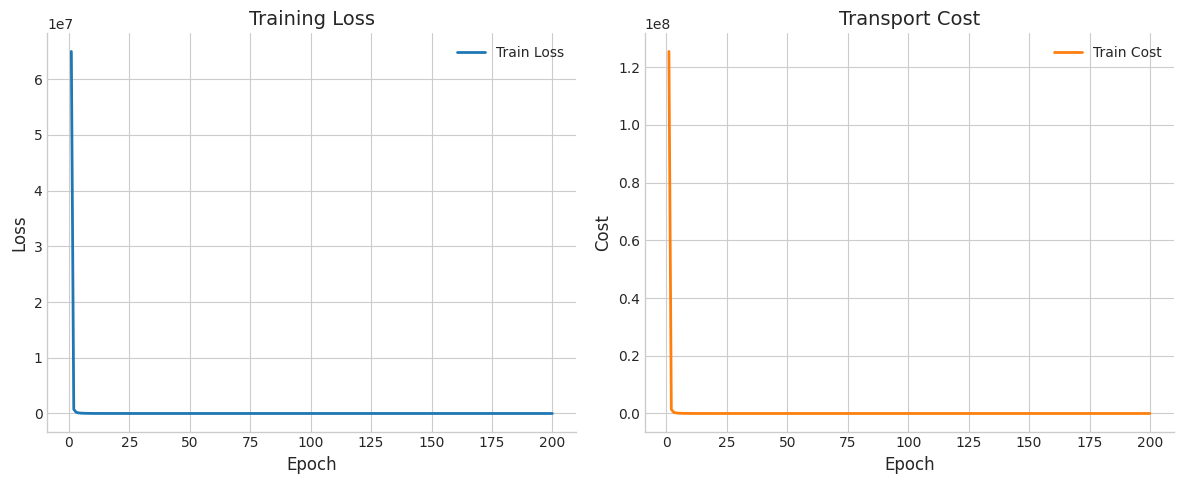

In [5]:
trainer.plot_train_metrics(plot_cost=True)

## Generation

To generate images, we sample $z \sim \mathcal{N}(0, I)$ and compute $\nabla \psi(z)$.

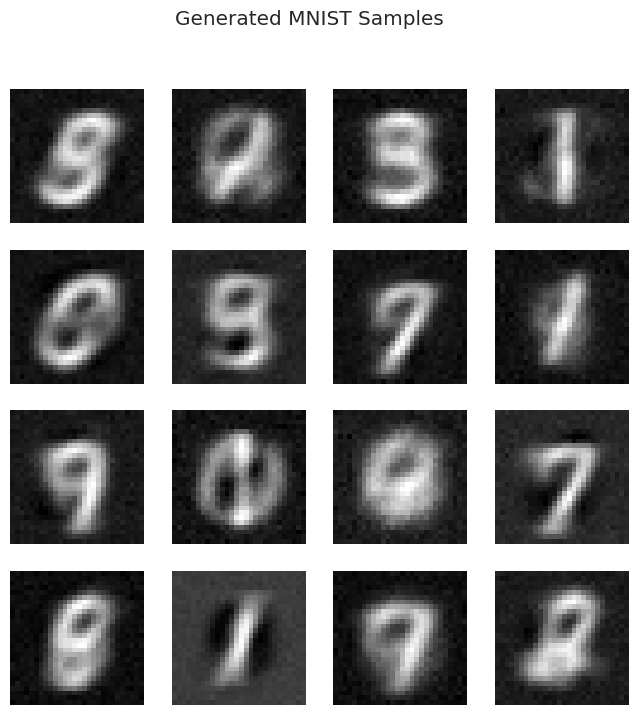

In [14]:
n_samples = 16

# Sample from Gaussian
z = torch.randn(n_samples, input_dim).to(DEVICE)

# Invert the map
# We use a zero initialization for x
model = trainer.model.to(DEVICE)
model.eval()
with torch.no_grad():
    samples = model(z).view(-1, 28, 28).cpu()

# Visualize
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].detach().numpy(), cmap='gray')
    ax.axis('off')
plt.suptitle("Generated MNIST Samples")
plt.show()